In [1]:
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from mpl_toolkits.mplot3d import Axes3D
import os


## extract_keypoint
* path : keypoint를 추출한 video 경로
* normalize_extraction : normalize keypoint의 저장 여부(dafault True)
* real_extraction : real keypoint의 저장 여부(dafault False)
* label : 미구현
* show_video : keypoint를 추출하는 과정에서 영상 출력 여부(dafault False)
* save_path : result가 저장되는 file 경로
* save_file_name : result가 저장되는 이름


save_path와 save_file_name을 모두 지정해야지 결과가 저장됨

In [2]:
# extract keypoint
def extract_keypoint(path, normalize_extraction = True, real_extraction = False, label = True,
                     save_path = None, show_video = False, save_file_name = None):
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_pose = mp.solutions.pose
    
    landmark_names = [
        'nose',
        'left_eye_inner',
        'left_eye',
        'left_eye_outer',
        'right_eye_inner',
        'right_eye',
        'right_eye_outer',
        'left_ear',
        'right_ear',
        'mouth_left',
        'mouth_right',
        'left_shoulder',
        'right_shoulder',
        'left_elbow',
        'right_elbow',
        'left_wrist', 'right_wrist',
        'left_pinky_1', 'right_pinky_1',
        'left_index_1', 'right_index_1',
        'left_thumb_2', 'right_thumb_2',
        'left_hip', 'right_hip',
        'left_knee', 'right_knee',
        'left_ankle', 'right_ankle',
        'left_heel', 'right_heel',
        'left_foot_index', 'right_foot_index',
    ]
    landmark_list = []
    for i in landmark_names:
        for j in ["_x", "_y", "_z"]:
            landmark_list.append(i + j)
    
    
    results_normalize_points = []
    results_real_points = []
    
    cap = cv2.VideoCapture(path)
    with mp_pose.Pose(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            success, image = cap.read()
            if not success:
                print("Done [%s] " % path)
                break

            image.flags.writeable = False
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_height, image_width, _ = image.shape
            results = pose.process(image)
            
            
            #list생성
            if(normalize_extraction == True):
                normalize_points = []
                for i in range(len(landmark_names)):
                    try:
                        normalize_points.append(results.pose_world_landmarks.landmark[i].x)
                        normalize_points.append(results.pose_world_landmarks.landmark[i].y)
                        normalize_points.append(results.pose_world_landmarks.landmark[i].z)
                        
                    except:
                        normalize_points.append(None)
                        normalize_points.append(None)
                        normalize_points.append(None)    
                results_normalize_points.append(normalize_points)
                

            
            if(real_extraction == True):
                real_points = []
                for i in range(len(landmark_names)):
                    try:
                        real_points.append(results.pose_landmarks.landmark[i].x * image_width)
                        real_points.append(results.pose_landmarks.landmark[i].y * image_height)
                        real_points.append(results.pose_landmarks.landmark[i].z)
                        
                    except:
                        real_points.append(None)
                        real_points.append(None)
                        real_points.append(None)
                        
                results_real_points.append(real_points)
            
            if(show_video == True):
                image.flags.writeable = True
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                mp_drawing.draw_landmarks(
                    image,
                    results.pose_landmarks,
                    mp_pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
                cv2.imshow('MediaPipe Pose', cv2.flip(image, 1))
                if cv2.waitKey(5) & 0xFF == 27:
                    break
                    
    cv2.destroyAllWindows()
    cap.release()
    if(save_path != None and save_file_name != None):
        #Normalize only
        if(normalize_extraction == True and real_extraction == False):
            point_normalize_dataframe = pd.DataFrame(columns = landmark_list, data = results_normalize_points)
            if not os.path.isdir(save_path):
                os.mkdir(save_path)
            point_normalize_dataframe.to_csv(save_path + save_file_name + "_noramlize.csv", index = False)
            return point_normalize_dataframe, _
        #real only
        elif(normalize_extraction == False and real_extraction == True):
            point_real_dataframe = pd.DataFrame(columns = landmark_list, data = results_real_points)
            if not os.path.isdir(save_path):
                os.mkdir(save_path)
            point_real_dataframe.to_csv(save_path + save_file_name + "_real.csv", index= False)
            return _, point_real_dataframe
    
        elif(normalize_extraction == True and real_extraction == True):
            point_normalize_dataframe = pd.DataFrame(columns = landmark_list, data = results_normalize_points)
            point_real_dataframe = pd.DataFrame(columns = landmark_list, data = results_real_points)
            if not os.path.isdir(save_path):
                os.mkdir(save_path)
            point_normalize_dataframe.to_csv(save_path + save_file_name + "_noramlize.csv", index = False)
            point_real_dataframe.to_csv(save_path + save_file_name + "_real.csv", index= False)
            return point_normalize_dataframe, point_real_dataframe


    
   

## compute_len_feature
* dataframe : keypoint가 담긴 dataframe
* path : keypoint가 담긴 .csv파일 경로
* drop_na : load한 dataframe에 Nan값이 있을 경우 drop 여부(default True)
* start, end : 어떤 keypoint에서 거리를 추출할 지 정함(default 23, 32/ hip, knee, ankle, heel, foot)
* save_path : result가 저장되는 file 경로
* save_file_name : result가 저장되는 이름


dataframe, path 중 하나에 데이터 혹은 경로를 넣어줘야함


save_path와 save_file_name을 모두 지정해야지 결과가 저장됨

In [3]:
#default start = 23 (hip, knee, ankle, heel, foot)
#
def compute_len_feature(dataframe = None, path = None,
                    drop_na = True, start = 23, end = 32, save_path = None, save_file_name = None):

    landmark_names = [
        'nose',
        'left_eye_inner',
        'left_eye',
        'left_eye_outer',
        'right_eye_inner',
        'right_eye',
        'right_eye_outer',
        'left_ear',
        'right_ear',
        'mouth_left',
        'mouth_right',
        'left_shoulder',
        'right_shoulder',
        'left_elbow',
        'right_elbow',
        'left_wrist', 'right_wrist',
        'left_pinky_1', 'right_pinky_1',
        'left_index_1', 'right_index_1',
        'left_thumb_2', 'right_thumb_2',
        'left_hip', 'right_hip',
        'left_knee', 'right_knee',
        'left_ankle', 'right_ankle',
        'left_heel', 'right_heel',
        'left_foot_index', 'right_foot_index',
    ]
    
    if(dataframe == None and path == None):
        return None
    
    else:
        if(dataframe == None):
            dataframe = pd.read_csv(path)
            
    if(drop_na == True):
        dataframe.dropna(axis = 0)
    
    result = pd.DataFrame()    
    landmark_list = list(dataframe.columns)
    
   
    for i in range(start, end, 2):
        x = dataframe[landmark_list[(i+1) * 3]] - dataframe[landmark_list[i * 3]]
        y = dataframe[landmark_list[(i+1) * 3 + 1]] - dataframe[landmark_list[i * 3 + 1]]
        point_len = np.sqrt(np.power(x, 2) + np.power(y, 2))
        point_depth = dataframe[landmark_list[(i+1) * 3 + 2]] - dataframe[landmark_list[i * 3 + 2]]
            
        string = landmark_names[i]
        string = string.replace('left', '')
        string = string.replace('right', '')
        string = string.replace('_', '')
        result[string + "_length"] = point_len
        result[string + "_depth"] = point_depth
            
    
    if(save_path != None and save_file_name != None):
        if not os.path.isdir(save_path):
            os.mkdir(save_path)
        result.to_csv(save_path + save_file_name + "_len_feauture.csv", index = False)
        return result

![ex_screenshot](./img/angle.png)


In [4]:
def compute_anlge(dataframe, midle_point, point_1, point_2, knee = False):
    
    landmark_list = list(dataframe.columns)
    angle = []
    
    
    if(knee == True):
        angle_1 = []
        angle_2 = []
        angle_3 = []
        
        p0 = np.array([dataframe[landmark_list[point_1 * 3]].tolist(), dataframe[landmark_list[(point_1 * 3) + 1]].tolist()])
        p1 = np.array([dataframe[landmark_list[midle_point * 3]].tolist(), dataframe[landmark_list[(midle_point * 3) + 1]].tolist()])
        p2 = np.array([dataframe[landmark_list[point_2 * 3]].tolist(), dataframe[landmark_list[(point_2 * 3) + 1]].tolist()])
        
        #angle1
        p_knee_1 = np.array([dataframe[landmark_list[point_1 * 3]].tolist(), dataframe[landmark_list[(midle_point * 3) + 1]].tolist()])

        for i in range(len(dataframe)):
            v0 = np.array(p0[:, i]) - np.array(p1[:, i])
            v1 = np.array(p_knee_1[:, i] - np.array(p1[:, i]))
            angle_1.append(np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1)))
        angle_1 = np.array(angle_1)  
        angle_1 = np.degrees(angle_1)
                          
        #angle2
        p_knee_2 = np.array([dataframe[landmark_list[point_2 * 3]].tolist(), dataframe[landmark_list[(midle_point * 3) + 1]].tolist()])
        for i in range(len(dataframe)):
            v0 = np.array(p0[:, i]) - np.array(p2[:, i])
            v1 = np.array(p_knee_2[:, i] - np.array(p1[:, i]))
            angle_2.append(np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1)))
        angle_2 = np.array(angle_2) 
        angle_2 = np.degrees(angle_2)
                          
        for i in range(len(dataframe)):
            v0 = np.array(p0[:, i]) - np.array(p1[:, i])
            v1 = np.array(p2[:, i]) - np.array(p1[:, i])
            angle_3.append(np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1)))
        angle_3 = np.array(angle_3)
        angle_3 = np.degrees(angle_3)
        angle_3 = 180 - angle_3
        return angle_1, angle_2, angle_3
    
    else:
        p0 = np.array([dataframe[landmark_list[point_1 * 3]].tolist(), dataframe[landmark_list[(point_1 * 3) + 1]].tolist()])
        p1 = np.array([dataframe[landmark_list[midle_point * 3]].tolist(), dataframe[landmark_list[(midle_point * 3) + 1]].tolist()])
        p2 = np.array([dataframe[landmark_list[point_2 * 3]].tolist(), dataframe[landmark_list[(point_2 * 3) + 1]].tolist()])
    
        for i in range(len(dataframe)):
            v0 = np.array(p0[:, i]) - np.array(p1[:, i])
            v1 = np.array(p2[:, i]) - np.array(p1[:, i])
            angle.append(np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1)))
        angle = np.array(angle)
        angle = np.degrees(angle)
        return angle

## compute_angle_feature
* dataframe : keypoint가 담긴 dataframe
* path : keypoint가 담긴 .csv파일 경로
* drop_na : load한 dataframe에 Nan값이 있을 경우 drop 여부(default True)
* data_abs : result 절댓값 여부(default False)
* hip, knee, ankle : angle을 뽑을 poit 부위 여부(default True)
* save_path : result가 저장되는 file 경로
* save_file_name : result가 저장되는 이름


dataframe, path 중 하나에 데이터 혹은 경로를 넣어줘야함


save_path와 save_file_name을 모두 지정해야지 결과가 저장됨

In [5]:
def compute_angle_feature(dataframe = None, path = None, drop_na = True, data_abs = False,
                          hip = True, knee = True, ankle = True, save_path = None, save_file_name = None):
    result = pd.DataFrame()  
    
    landmark_names = [
        'nose',
        'left_eye_inner',
        'left_eye',
        'left_eye_outer',
        'right_eye_inner',
        'right_eye',
        'right_eye_outer',
        'left_ear',
        'right_ear',
        'mouth_left',
        'mouth_right',
        'left_shoulder',
        'right_shoulder',
        'left_elbow',
        'right_elbow',
        'left_wrist', 'right_wrist',
        'left_pinky_1', 'right_pinky_1',
        'left_index_1', 'right_index_1',
        'left_thumb_2', 'right_thumb_2',
        'left_hip', 'right_hip',
        'left_knee', 'right_knee',
        'left_ankle', 'right_ankle',
        'left_heel', 'right_heel',
        'left_foot_index', 'right_foot_index',
    ]
    
    if(dataframe == None and path == None):
        return None
    
    else:
        if(dataframe == None):
            dataframe = pd.read_csv(path)
            
    if(drop_na == True):
        dataframe.dropna(axis = 0)
        
    if(hip == True):
        angle_left_hip = compute_anlge(dataframe, 23, 11, 25)
        angle_right_hip = compute_anlge(dataframe, 24, 12, 26)
        result['left_hip_anlge'] = angle_left_hip
        result['right_hip_anlge'] = angle_right_hip
       
    if(knee == True):
        angle_left_1_knee, angle_left_2_knee, angle_left_3_knee = compute_anlge(dataframe, 25, 23, 27, knee = True)
        result['left_knee_anlge_1'], result['left_knee_anlge_2'], result['left_knee_anlge_3'] = angle_left_1_knee, angle_left_2_knee, angle_left_3_knee

        angle_right_1_knee, angle_right_2_knee, angle_right_3_knee = compute_anlge(dataframe, 26, 24, 28, knee =True)
        result['right_knee_anlge_1'], result['right_knee_anlge_2'], result['right_knee_anlge_3'] = angle_right_1_knee, angle_right_2_knee, angle_right_3_knee
    
    if(ankle == True):
        
        angle_left_1_ankle = compute_anlge(dataframe, 27, 25, 31)
        angle_left_2_ankle = compute_anlge(dataframe, 27, 25, 29) 
        angle_right_1_ankle = compute_anlge(dataframe, 28, 26, 32)
        angle_right_2_ankle = compute_anlge(dataframe, 28, 26, 30)
        result['left_ankle_angle_1'] = angle_left_1_ankle
        result['left_ankle_angle_2'] = angle_left_1_ankle
        result['right_ankle_angle_1'] = angle_right_1_ankle 
        result['right_ankle_angle_2'] = angle_right_2_ankle
    
    if(save_path != None and save_file_name != None):
        if not os.path.isdir(save_path):
            os.mkdir(save_path)
            
    if(data_abs == True):
        result = np.abs(result)
            
    result.to_csv(save_path + save_file_name + "_angle_feauture.csv", index = False)
    return result
        


In [6]:
normalize, _ = extract_keypoint(path = "demo/demo.mp4", save_path = "demo/dataset/", show_video = True, save_file_name = "demo")

Done [demo/demo.mp4] 


In [7]:
demo = pd.read_csv("demo/dataset/demo_noramlize.csv")

In [8]:
feature_angle = compute_angle_feature(path = "demo/dataset/demo_noramlize.csv", save_path = "demo/feature/", save_file_name = "demo")
feature_len = compute_len_feature(path = "demo/dataset/demo_noramlize.csv", save_path = "demo/feature/", save_file_name = "demo")

<AxesSubplot:>

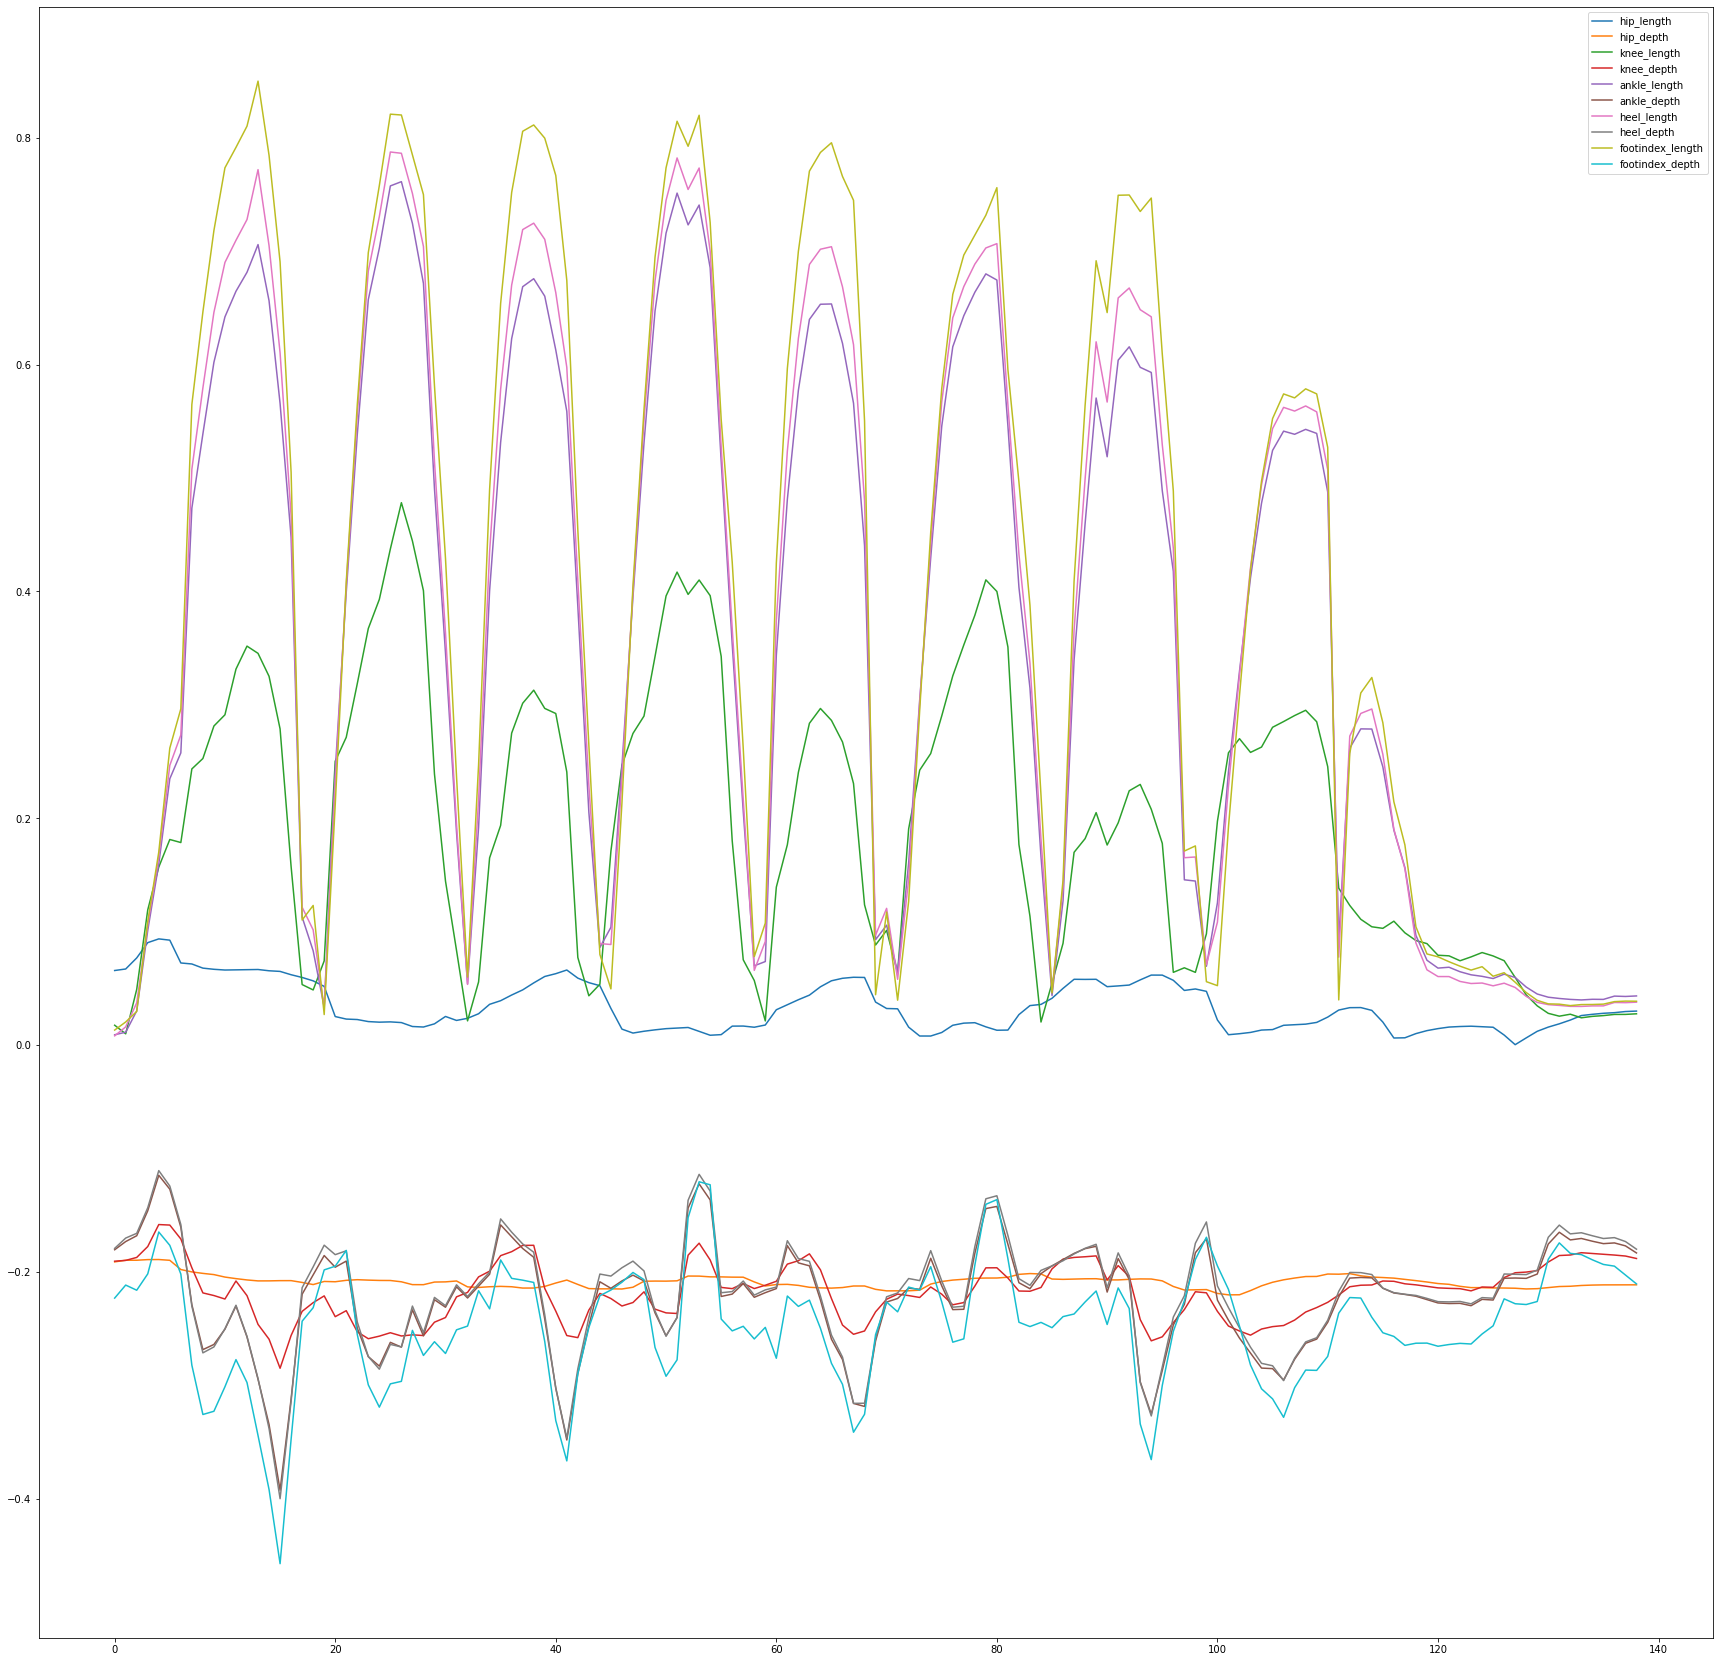

In [9]:
feature_len.plot(figsize = (30,30))

<AxesSubplot:>

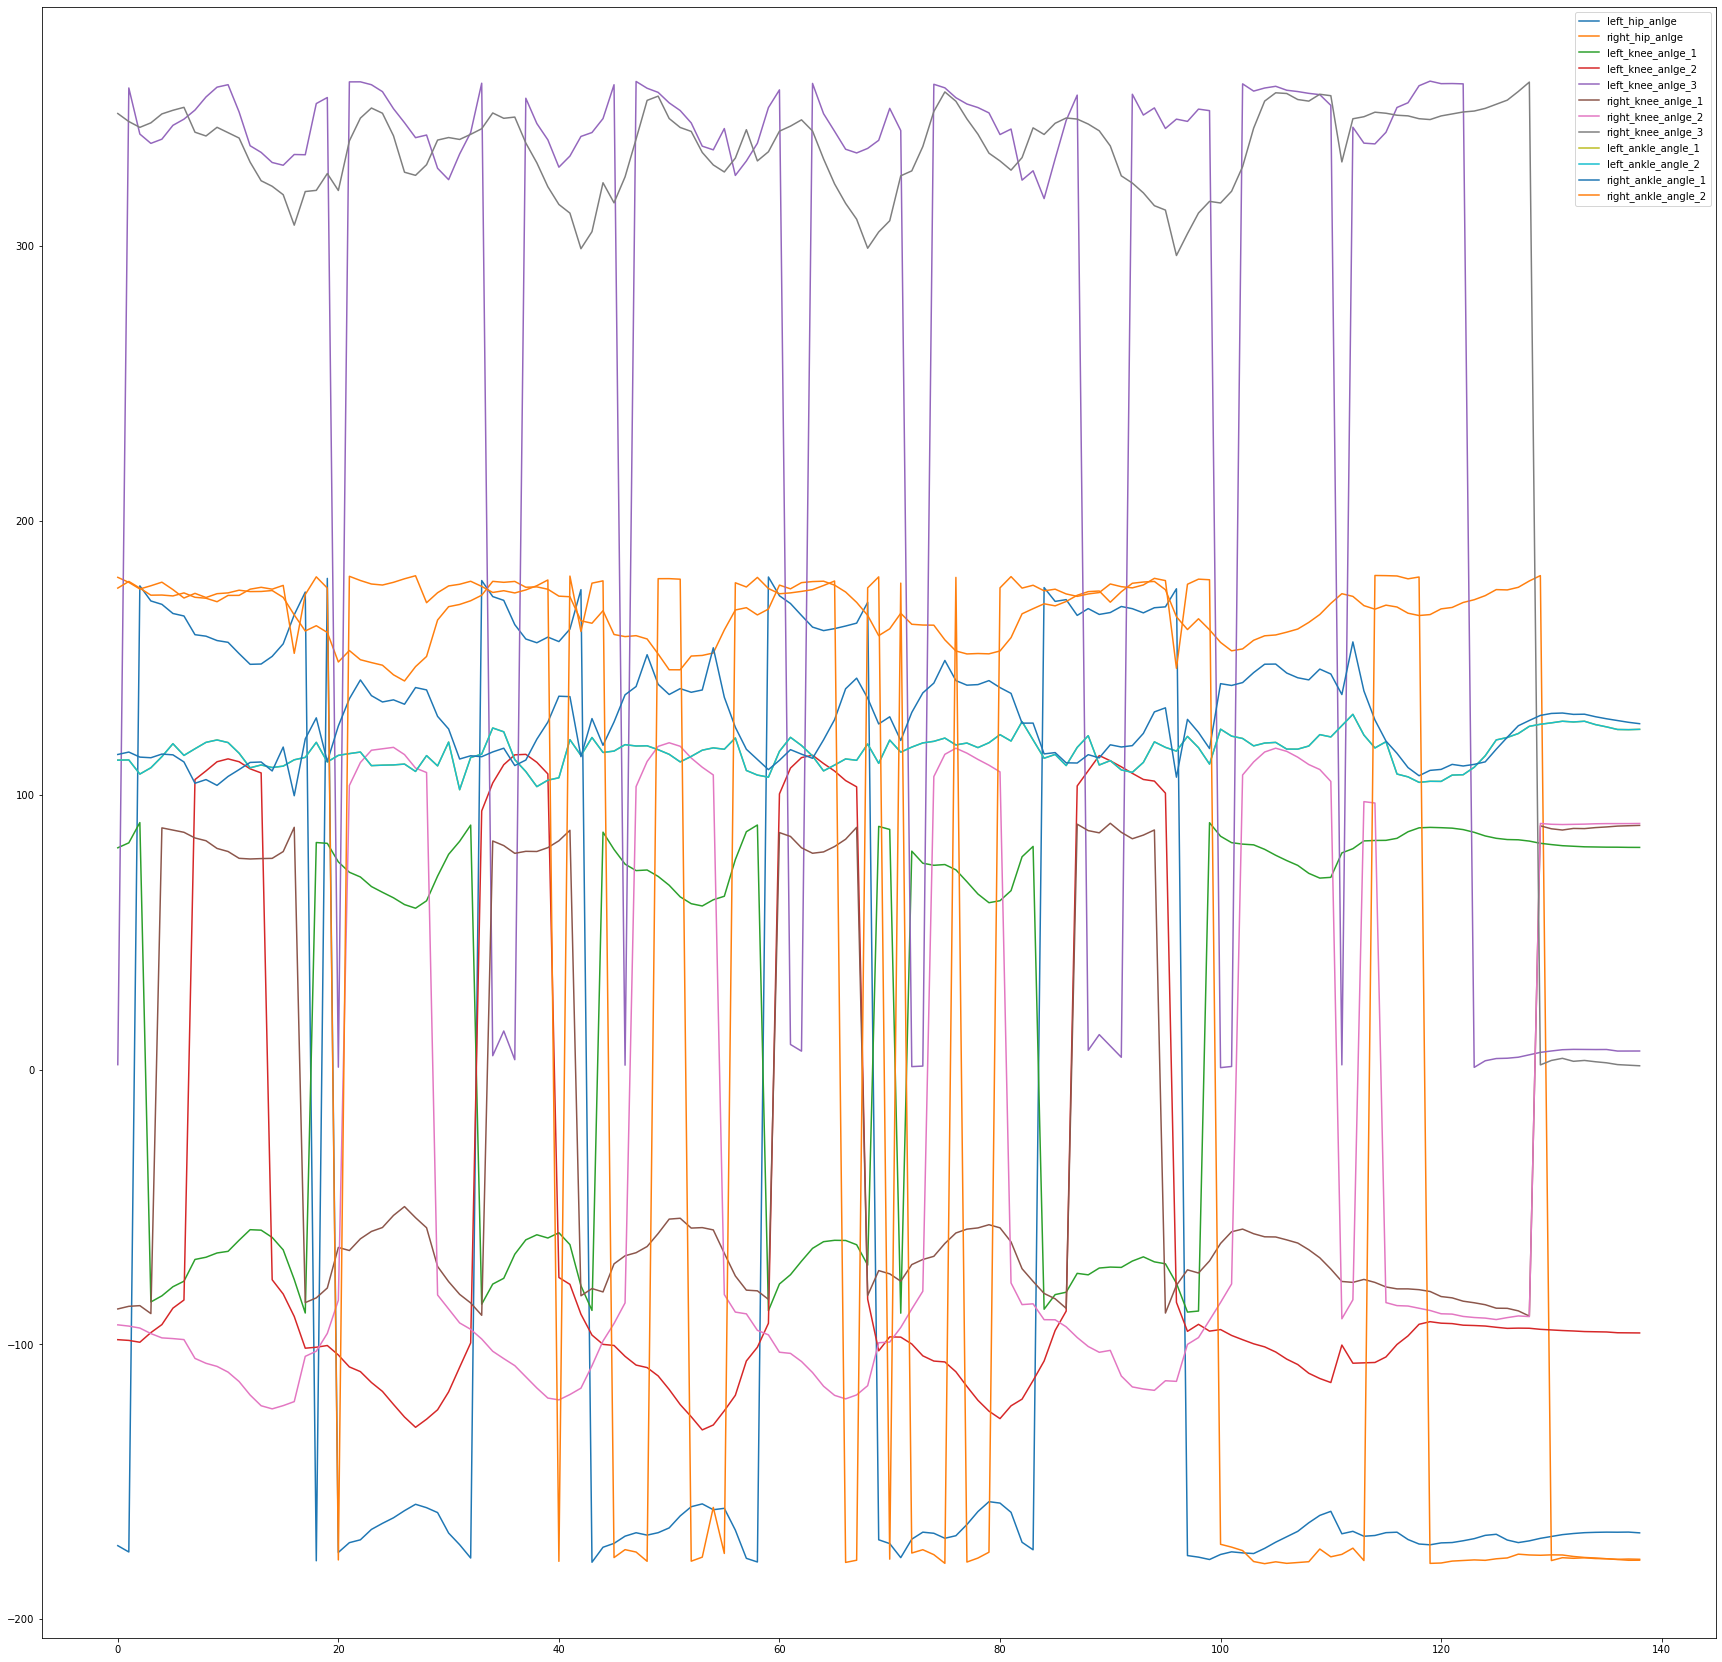

In [10]:
feature_angle.plot(figsize = (30,30))

<AxesSubplot:>

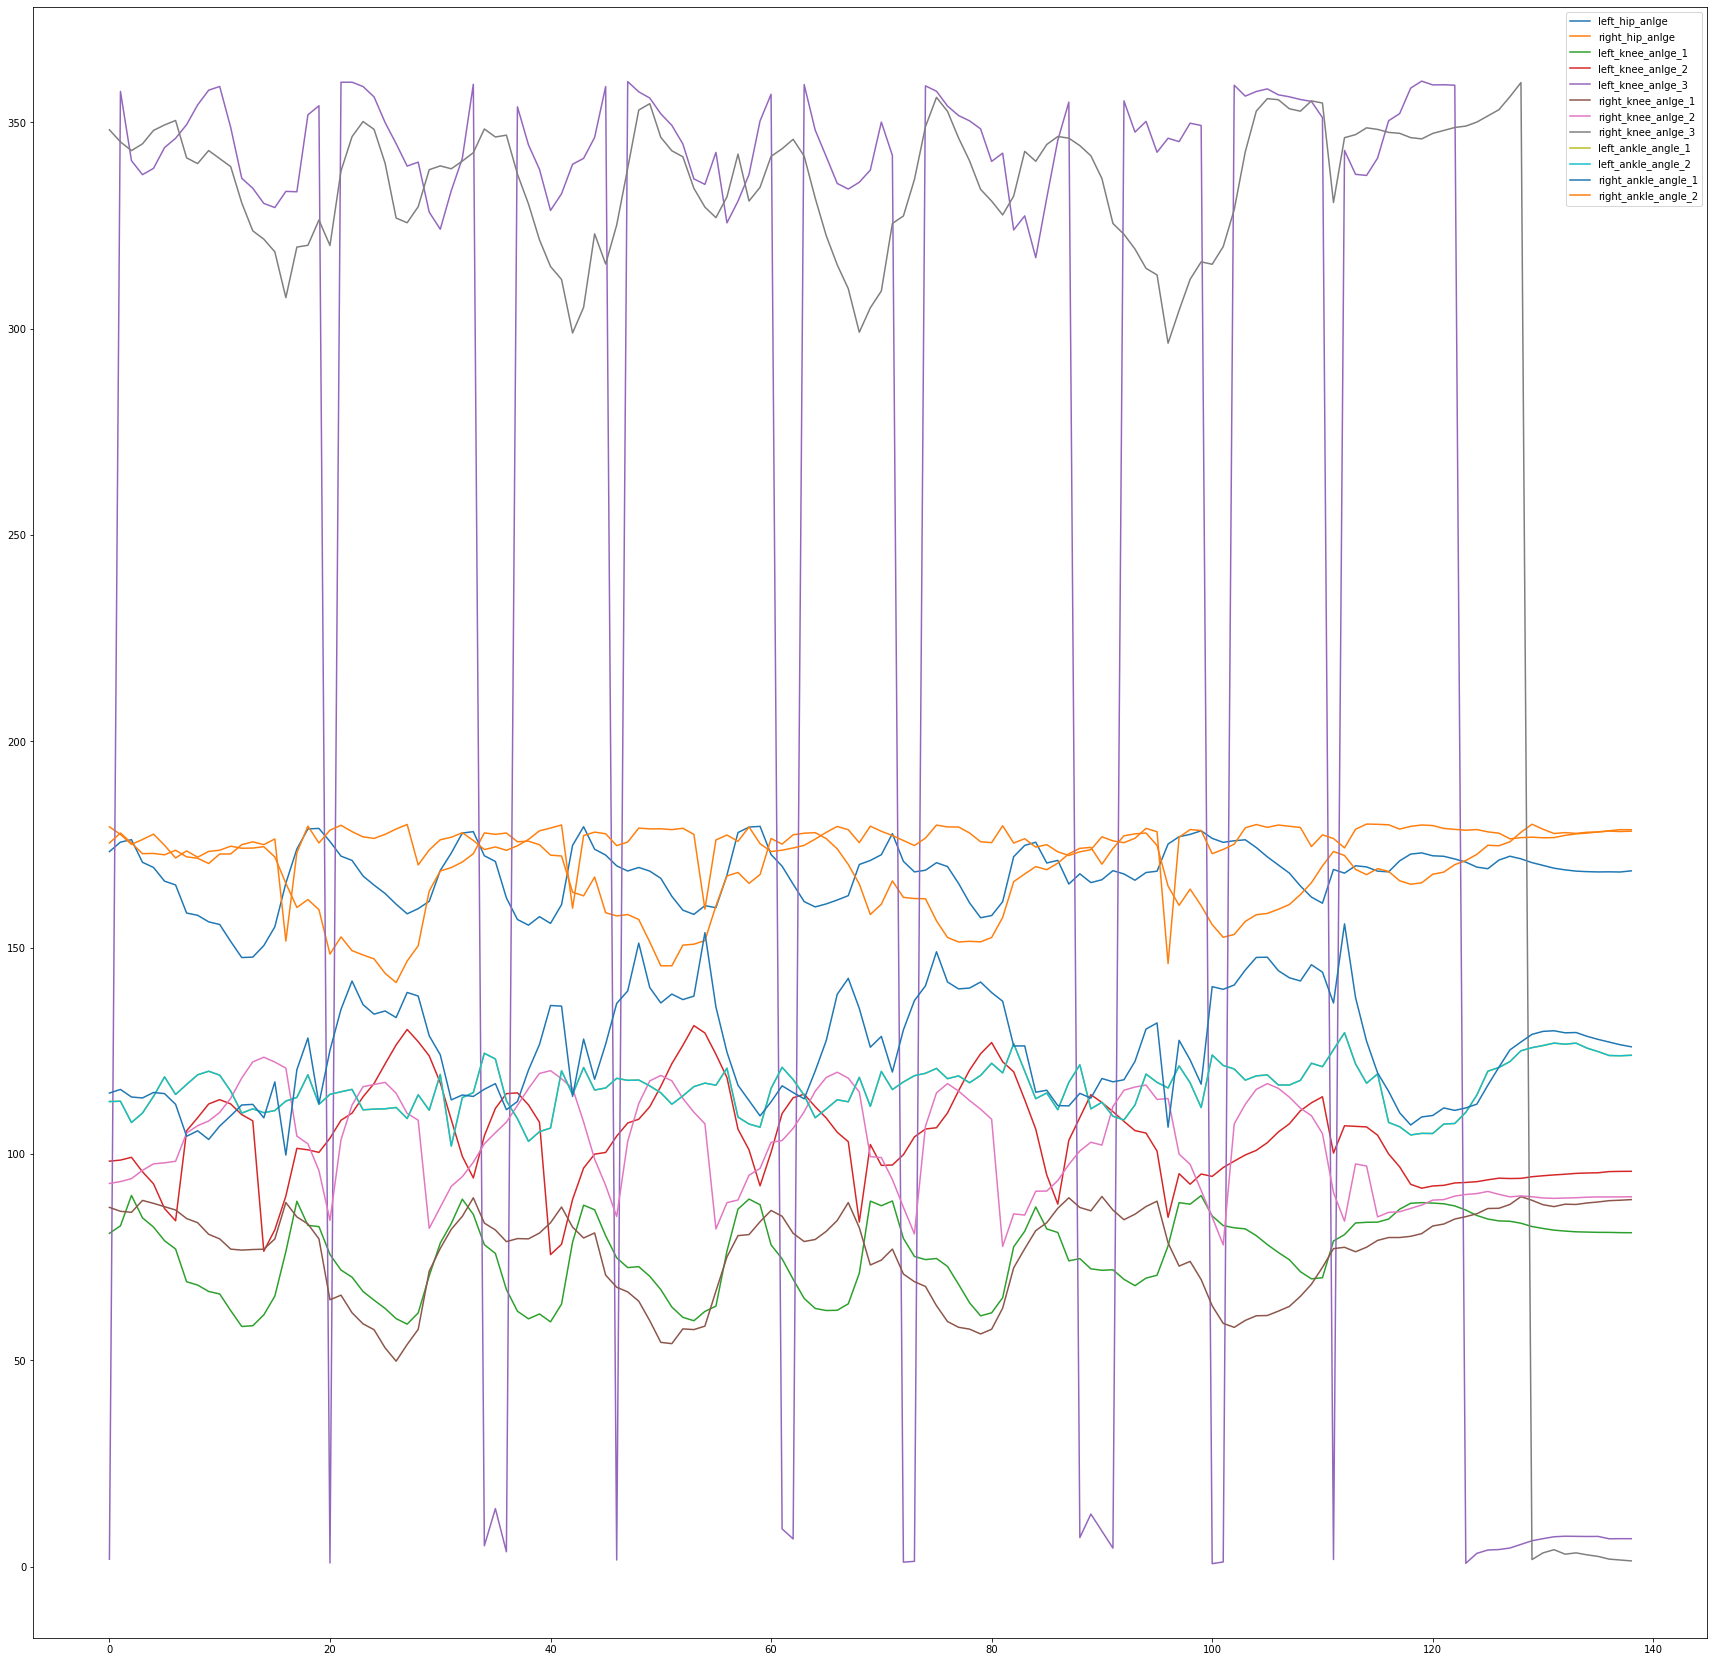

In [11]:
#angle을 절댓값 씌웠을 때
np.abs(feature_angle).plot(figsize = (30,30))

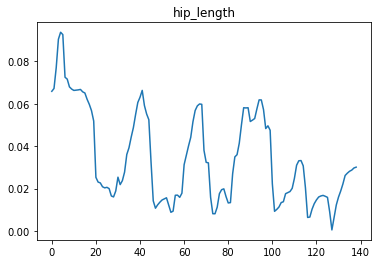

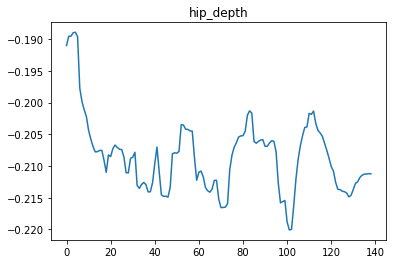

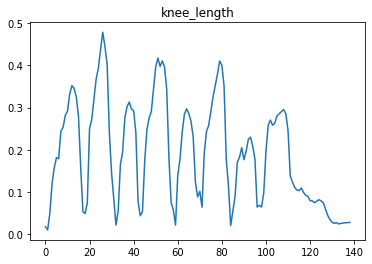

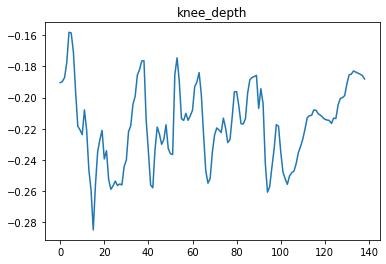

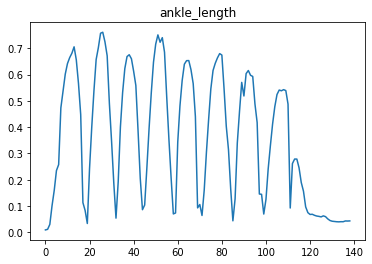

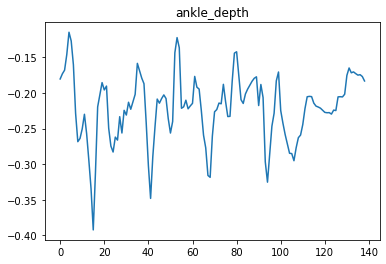

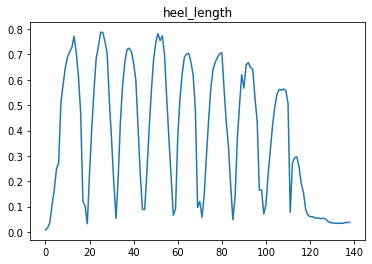

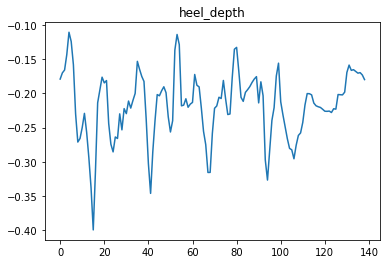

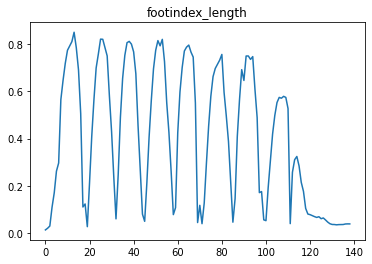

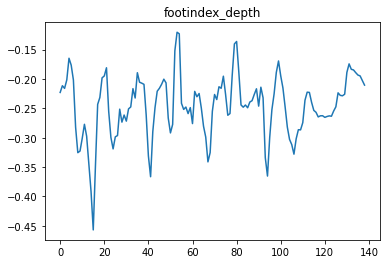

In [12]:
#len EDA
for i in list(feature_len.columns):
    plt.plot(feature_len[i])
    plt.title(i)
    plt.show()

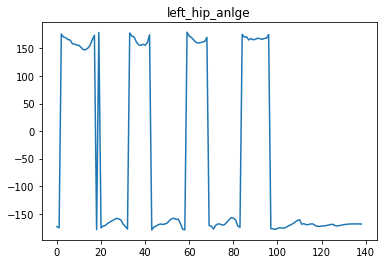

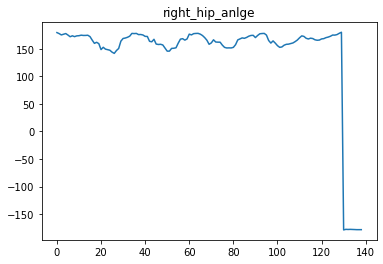

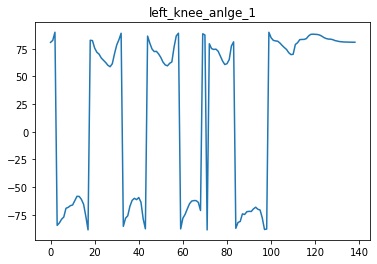

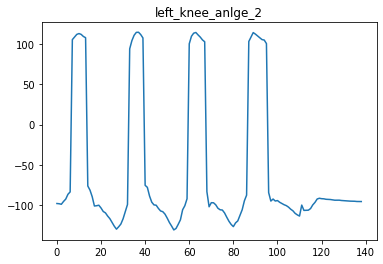

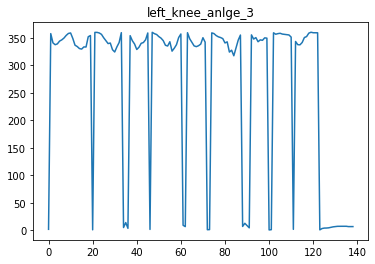

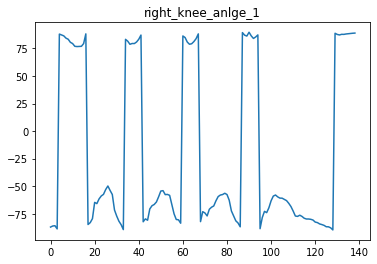

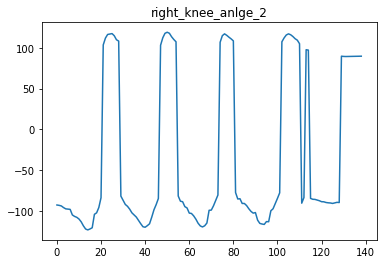

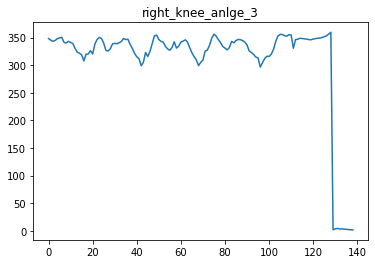

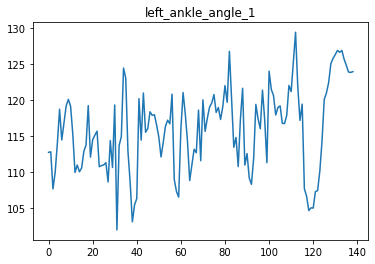

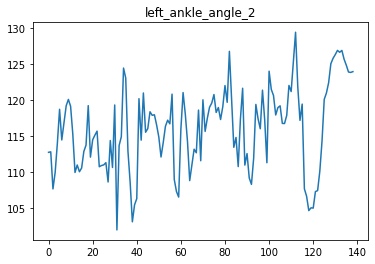

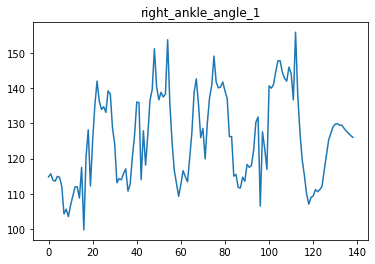

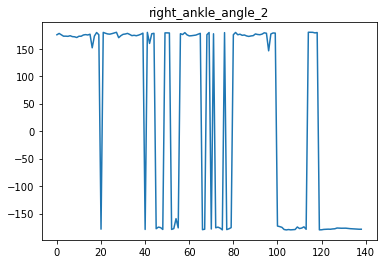

In [13]:
#angle EDA
for i in list(feature_angle.columns):
    plt.plot(feature_angle[i])
    plt.title(i)
    plt.show()